In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import sys
#!{sys.executable} -m pip install shap
import shap
#!{sys.executable} -m pip install lime
from lime import lime_tabular
import warnings
warnings.filterwarnings('ignore')

try:
    get_ipython()
    JUPYTER_MODE = True
    import matplotlib
    matplotlib.use('inline')
except NameError:
    JUPYTER_MODE = False

plt.style.use('default')  
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.color'] = '#E0E0E0'

pastel_colors = ['#AEC6CF', '#FFB7B2', '#B4E7CE', '#E1BEE7', '#FFDAB9', 
                 '#C5E1A5', '#FFCCBC', '#B2DFDB', '#F8BBD0', '#DCEDC8']
sns.set_palette(pastel_colors)

In [2]:
class MyModelAnalyzer:
    
    def __init__(self, mymodel, X_train, y_train, X_test, y_test, feature_names=None):
        self.model = mymodel
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names or [f'Feature_{i}' for i in range(X_train.shape[1])]
 
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Features: {len(self.feature_names)}")
        print(f"Classes: {len(np.unique(y_train))}")
        
    def basic_performance(self):
        train_pred = self.model.predict(self.X_train)
        test_pred = self.model.predict(self.X_test)
        
        train_acc = accuracy_score(self.y_train, train_pred)
        test_acc = accuracy_score(self.y_test, test_pred)
        
        print(f"\nTraining Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Overfitting?: {train_acc - test_acc:.4f} rozdíl")

        cm = confusion_matrix(self.y_test, test_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - MyModel')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        if JUPYTER_MODE:
            plt.show()
        else:
            plt.savefig('analysis_1_confusion_matrix.png', dpi=300)
            plt.close()
    
        return {'train_acc': train_acc, 'test_acc': test_acc}
    
    def probe_decision_boundaries(self, n_samples=1000):
        print(f"Generate {n_samples} probe samples...")
        
        feature_ranges = []
        for i in range(self.X_train.shape[1]):
            min_val = self.X_train[:, i].min()
            max_val = self.X_train[:, i].max()
            feature_ranges.append((min_val, max_val))

        probe_samples = np.random.uniform(
            low=[r[0] for r in feature_ranges],
            high=[r[1] for r in feature_ranges],
            size=(n_samples, self.X_train.shape[1])
        )
        
        probe_predictions = self.model.predict(probe_samples)
        unique, counts = np.unique(probe_predictions, return_counts=True)

        for label, count in zip(unique, counts):
            pct = (count / n_samples) * 100
            print(f"   Class {label}: {count} ({pct:.1f}%)")

        if hasattr(self.model, 'predict_proba'):
            probe_proba = self.model.predict_proba(probe_samples)
            max_proba = probe_proba.max(axis=1)

            print(f"   Average confidence: {max_proba.mean():.3f}")
            print(f"   Median confidence: {np.median(max_proba):.3f}")
            print(f"   Low confidence (<0.6): {(max_proba < 0.6).sum()} samples")

            plt.figure(figsize=(10, 6))
            plt.hist(max_proba, bins=50, edgecolor='white', alpha=0.8, color='#B4E7CE')
            plt.axvline(max_proba.mean(), color='#FF6B6B', linestyle='--', 
                       linewidth=2, label=f'Mean: {max_proba.mean():.3f}')
            plt.title('Distribution of Model Confidence on Probe Samples', fontsize=14, pad=15)
            plt.xlabel('Max Probability (Confidence)', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.legend(fontsize=11)
            plt.tight_layout()
            if JUPYTER_MODE:
                plt.show()
            else:
                plt.savefig('analysis_2_confidence_distribution.png', dpi=300)
                plt.close()
        
        return probe_samples, probe_predictions
    
    def feature_importance_shap(self, max_samples=100):

        print(f"SHAP for values {max_samples} samples...")
        X_sample = self.X_test[:max_samples]
        
        # SHAP explainer
        explainer = shap.Explainer(self.model.predict, self.X_train[:100])
        shap_values = explainer(X_sample)

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_sample, feature_names=self.feature_names, 
                         show=False, cmap="managua")
        plt.tight_layout()  
        if JUPYTER_MODE:
            plt.show()
        else:
            plt.savefig('analysis_3_shap_summary.png', dpi=300, bbox_inches='tight')
            plt.close()

        feature_importance = np.abs(shap_values.values).mean(axis=0)

        if len(feature_importance.shape) > 1:
            feature_importance = feature_importance.mean(axis=1)
        
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print("\n Decision FEATURES:")
        for i, row in importance_df.head(10).iterrows():
            print(f"   {row['feature']}: {row['importance']:.4f}")

        plt.figure(figsize=(12, 6))
        colors_gradient = plt.cm.Pastel1(np.linspace(0, 1, 15))
        plt.barh(importance_df.head(15)['feature'], 
                importance_df.head(15)['importance'],
                color=colors_gradient)
        plt.xlabel('Mean |SHAP value|', fontsize=12)
        plt.title('Feature Importance (SHAP)', fontsize=14, pad=15)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        if JUPYTER_MODE:
            plt.show()
        else:
            plt.savefig('analysis_4_feature_importance.png', dpi=300)
            plt.close()
        
        return importance_df
    
    def lime_local_explanation(self, sample_idx=0):

        # LIME explainer
        explainer = lime_tabular.LimeTabularExplainer(
            self.X_train,
            feature_names=self.feature_names,
            class_names=[f'Class_{i}' for i in np.unique(self.y_train)],
            mode='classification'
        )

        sample = self.X_test[sample_idx]
        exp = explainer.explain_instance(sample, self.model.predict_proba, num_features=10)
        
        print(f"\n Test sample #{sample_idx}:")
        print(f"   Existing class: {self.y_test[sample_idx]}")
        print(f"   Predicted class: {self.model.predict([sample])[0]}")
        
        if hasattr(self.model, 'predict_proba'):
            proba = self.model.predict_proba([sample])[0]
            print(f"   Confidence: {proba.max():.3f}")
        
        fig = exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for Sample #{sample_idx}')
        ax = plt.gca()
        for patch in ax.patches:
            if patch.get_facecolor()[0] > 0.5: 
                patch.set_facecolor('#B4E7CE')
            else:
                patch.set_facecolor('#FFB7B2')
        plt.tight_layout()
        if JUPYTER_MODE:
            plt.show()
        else:
            plt.savefig('analysis_5_lime_explanation.png', dpi=300)
            plt.close()
        
        return exp
    
    def adversarial_probing(self, n_perturbations=100, epsilon=0.1):

        print(f"Testing {n_perturbations} num pertubation with epsilon={epsilon}...")
        
        successful_attacks = 0
        confidence_changes = []
        
        for i in range(min(n_perturbations, len(self.X_test))):
            original = self.X_test[i:i+1]
            original_pred = self.model.predict(original)[0]
            perturbation = np.random.uniform(-epsilon, epsilon, original.shape)
            perturbed = original + perturbation      
            perturbed_pred = self.model.predict(perturbed)[0]
            if original_pred != perturbed_pred:
                successful_attacks += 1
            
            # Confidence change
            if hasattr(self.model, 'predict_proba'):
                orig_conf = self.model.predict_proba(original)[0].max()
                pert_conf = self.model.predict_proba(perturbed)[0].max()
                confidence_changes.append(abs(orig_conf - pert_conf))
        
        attack_success_rate = (successful_attacks / n_perturbations) * 100
        
        print(f"\nAdversarial probing:")
        print(f"   Success changes prediction: {successful_attacks}/{n_perturbations}")
        print(f"   Success rate: {attack_success_rate:.2f}%")
        
        if confidence_changes:
            print(f"   Changes of confidence: {np.mean(confidence_changes):.4f}")
            print(f"   Max changes of confidence: {np.max(confidence_changes):.4f}")

        robustness = 100 - attack_success_rate
        print(f"\nModel Robustness Score: {robustness:.1f}/100")
        
        if robustness < 50:
            print("    WARNING: The model is very sensitive to small changes!")
        elif robustness < 80:
            print("    The model is of medium robustness.")
        else:
            print("   The model is relatively robust.")
        
        return attack_success_rate
    
    def build_mimic_model(self):
        pseudo_labels_train = self.model.predict(self.X_train)
        pseudo_labels_test = self.model.predict(self.X_test)
        
        # Training decision for "pseudo labels"
        #mimic_model = DecisionTreeClassifier(max_depth=10, random_state=42)
        mimic_model = DecisionTreeClassifier(
                            max_depth=8,           # Limit depth
                            min_samples_split=20,  # Min samples pro split
                            min_samples_leaf=10,   # Min samples in list
                            max_leaf_nodes=50,     # Max count list
                            random_state=42)
        
        mimic_model.fit(self.X_train, pseudo_labels_train)
        
        # Evaluation
        mimic_train_acc = accuracy_score(pseudo_labels_train, 
                                        mimic_model.predict(self.X_train))
        mimic_test_acc = accuracy_score(pseudo_labels_test, 
                                       mimic_model.predict(self.X_test))
        
        print(f"\n Mimic Model Performance:")
        print(f"   Train fidelity: {mimic_train_acc:.4f}")
        print(f"   Test fidelity: {mimic_test_acc:.4f}")
        
        if mimic_test_acc > 0.80:
            print("    High fidelity - the decision tree approximates the analysed model well!")
        elif mimic_test_acc > 0.65:
            print("     Medium fidelity - tree captures basic logic")
        else:
            print("    Low fidelity - model is too complex")
        
        # Vizualisation decision tree
        plt.figure(figsize=(20, 12))
        plot_tree(mimic_model, 
                 feature_names=self.feature_names,
                 class_names=[f'Class_{i}' for i in np.unique(self.y_train)],
                 filled=True,
                 rounded=True,
                 fontsize=10)
        plt.title('Interpretable Mimic Model - Decision Tree', fontsize=16, pad=20)
        plt.tight_layout()
        if JUPYTER_MODE:
            plt.show()
        else:
            plt.savefig('analysis_6_mimic_tree.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # Feature importance from tree
        tree_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': mimic_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\n Decision Tree Feature Importance:")
        for i, row in tree_importance.head(10).iterrows():
            if row['importance'] > 0:
                print(f"   {row['feature']}: {row['importance']:.4f}")
        
        return mimic_model, mimic_test_acc

        
    def run_all_analysis(self):
        self.basic_performance()
        self.probe_decision_boundaries()
        importance = self.feature_importance_shap()
        self.lime_local_explanation()
        self.adversarial_probing()
        mimic_model, fidelity = self.build_mimic_model()


In [3]:
def create_demo_model():

    from sklearn.datasets import make_classification
    X, y = make_classification(
        n_samples=1000,
        n_features=20,
        n_informative=15,
        n_redundant=5,
        n_classes=3,
        random_state=42
    )
    
    feature_names = [f'Feature_{i}' for i in range(20)]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #mymodel = RandomForestClassifier(n_estimators=100, random_state=42)
    mymodel = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
    mymodel.fit(X_train, y_train)
    return mymodel, X_train, y_train, X_test, y_test, feature_names

model, X_train, y_train, X_test, y_test, features = create_demo_model()

Training samples: 700
Test samples: 300
Features: 20
Classes: 3

Training Accuracy: 0.8571
Test Accuracy: 0.6667
Overfitting?: 0.1905 rozdíl


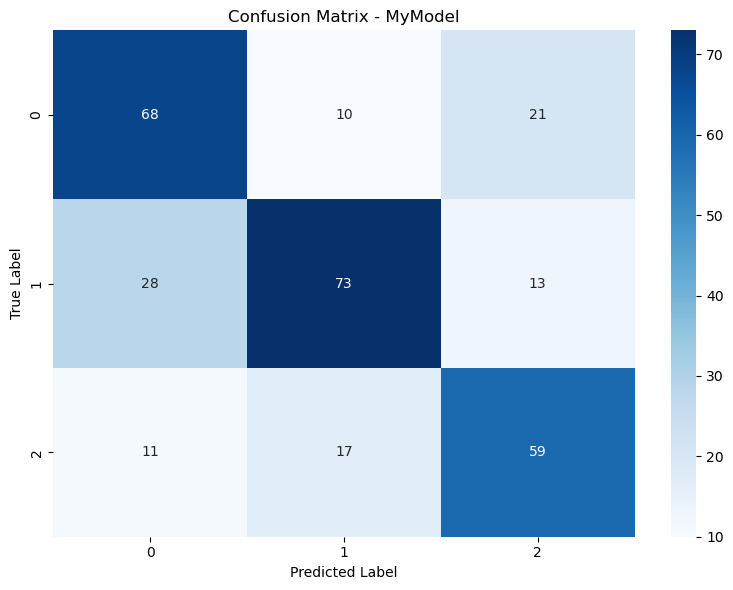

Generate 1000 probe samples...
   Class 0: 434 (43.4%)
   Class 1: 215 (21.5%)
   Class 2: 351 (35.1%)
   Average confidence: 0.499
   Median confidence: 0.482
   Low confidence (<0.6): 845 samples


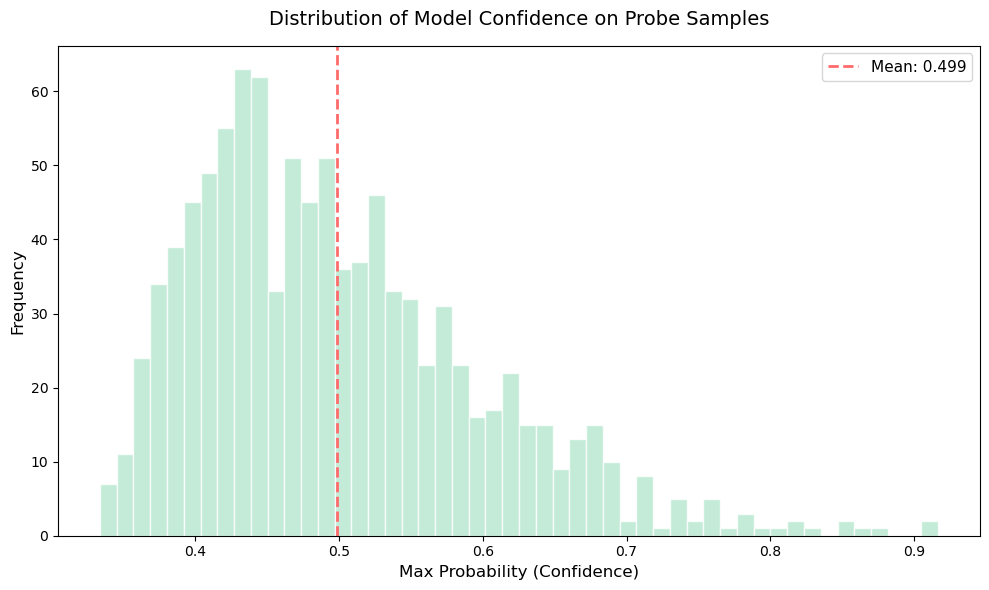

SHAP for values 100 samples...


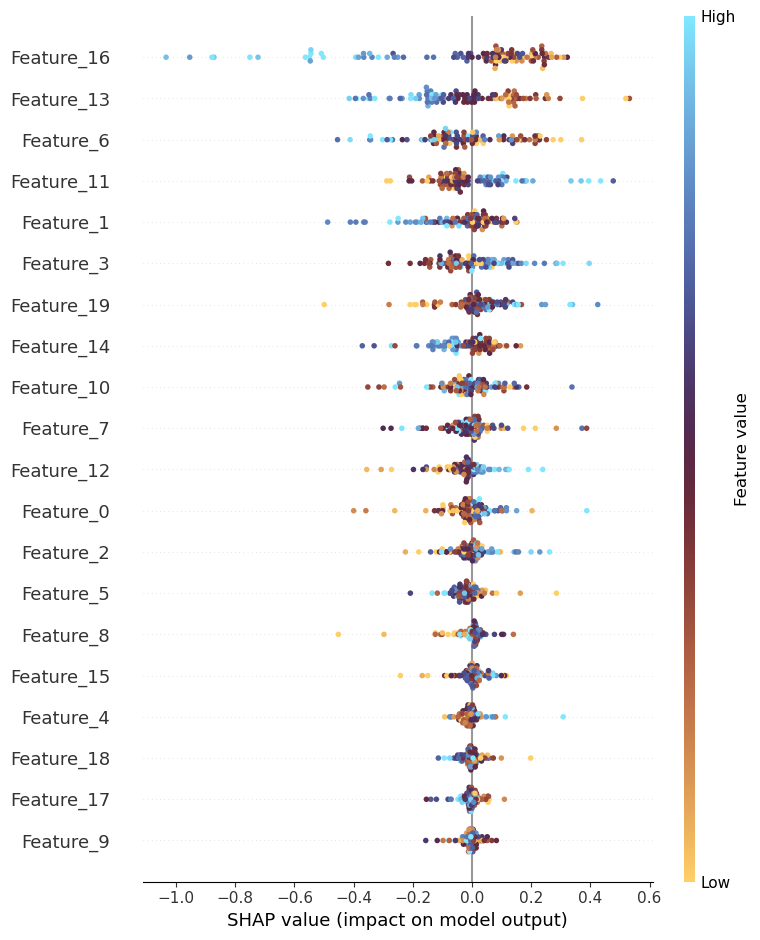


 Decision FEATURES:
   Feature_16: 0.2310
   Feature_13: 0.1466
   Feature_6: 0.1265
   Feature_11: 0.0994
   Feature_1: 0.0898
   Feature_3: 0.0859
   Feature_19: 0.0786
   Feature_14: 0.0712
   Feature_10: 0.0707
   Feature_7: 0.0623


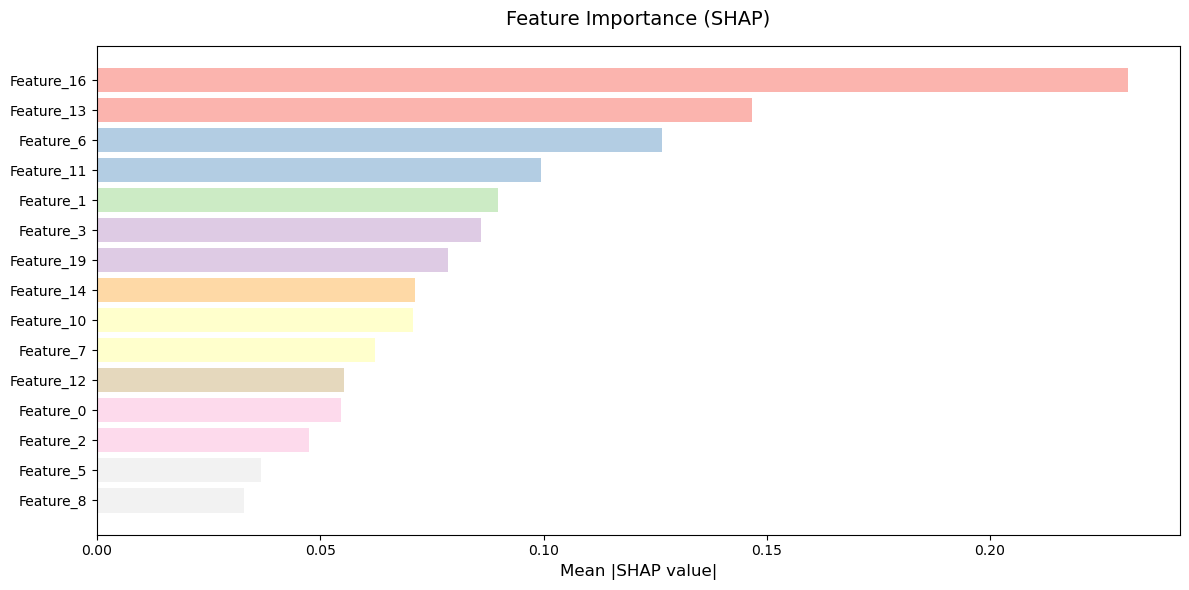


 Test sample #0:
   Existing class: 0
   Predicted class: 0
   Confidence: 0.455


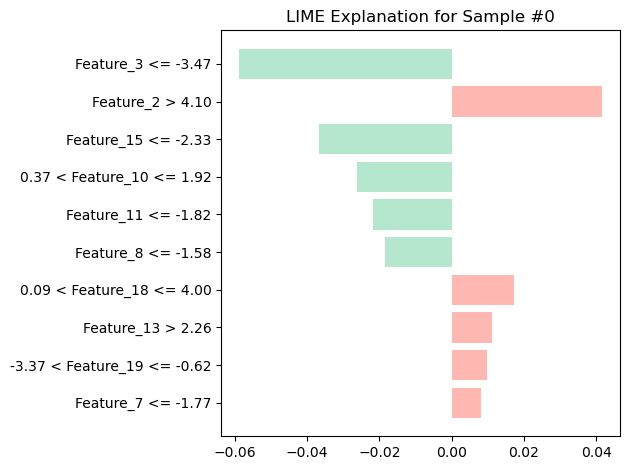

Testing 100 num pertubation with epsilon=0.1...

Adversarial probing:
   Success changes prediction: 3/100
   Success rate: 3.00%
   Changes of confidence: 0.0124
   Max changes of confidence: 0.1687

Model Robustness Score: 97.0/100
   The model is relatively robust.

 Mimic Model Performance:
   Train fidelity: 0.8514
   Test fidelity: 0.6867
     Medium fidelity - tree captures basic logic


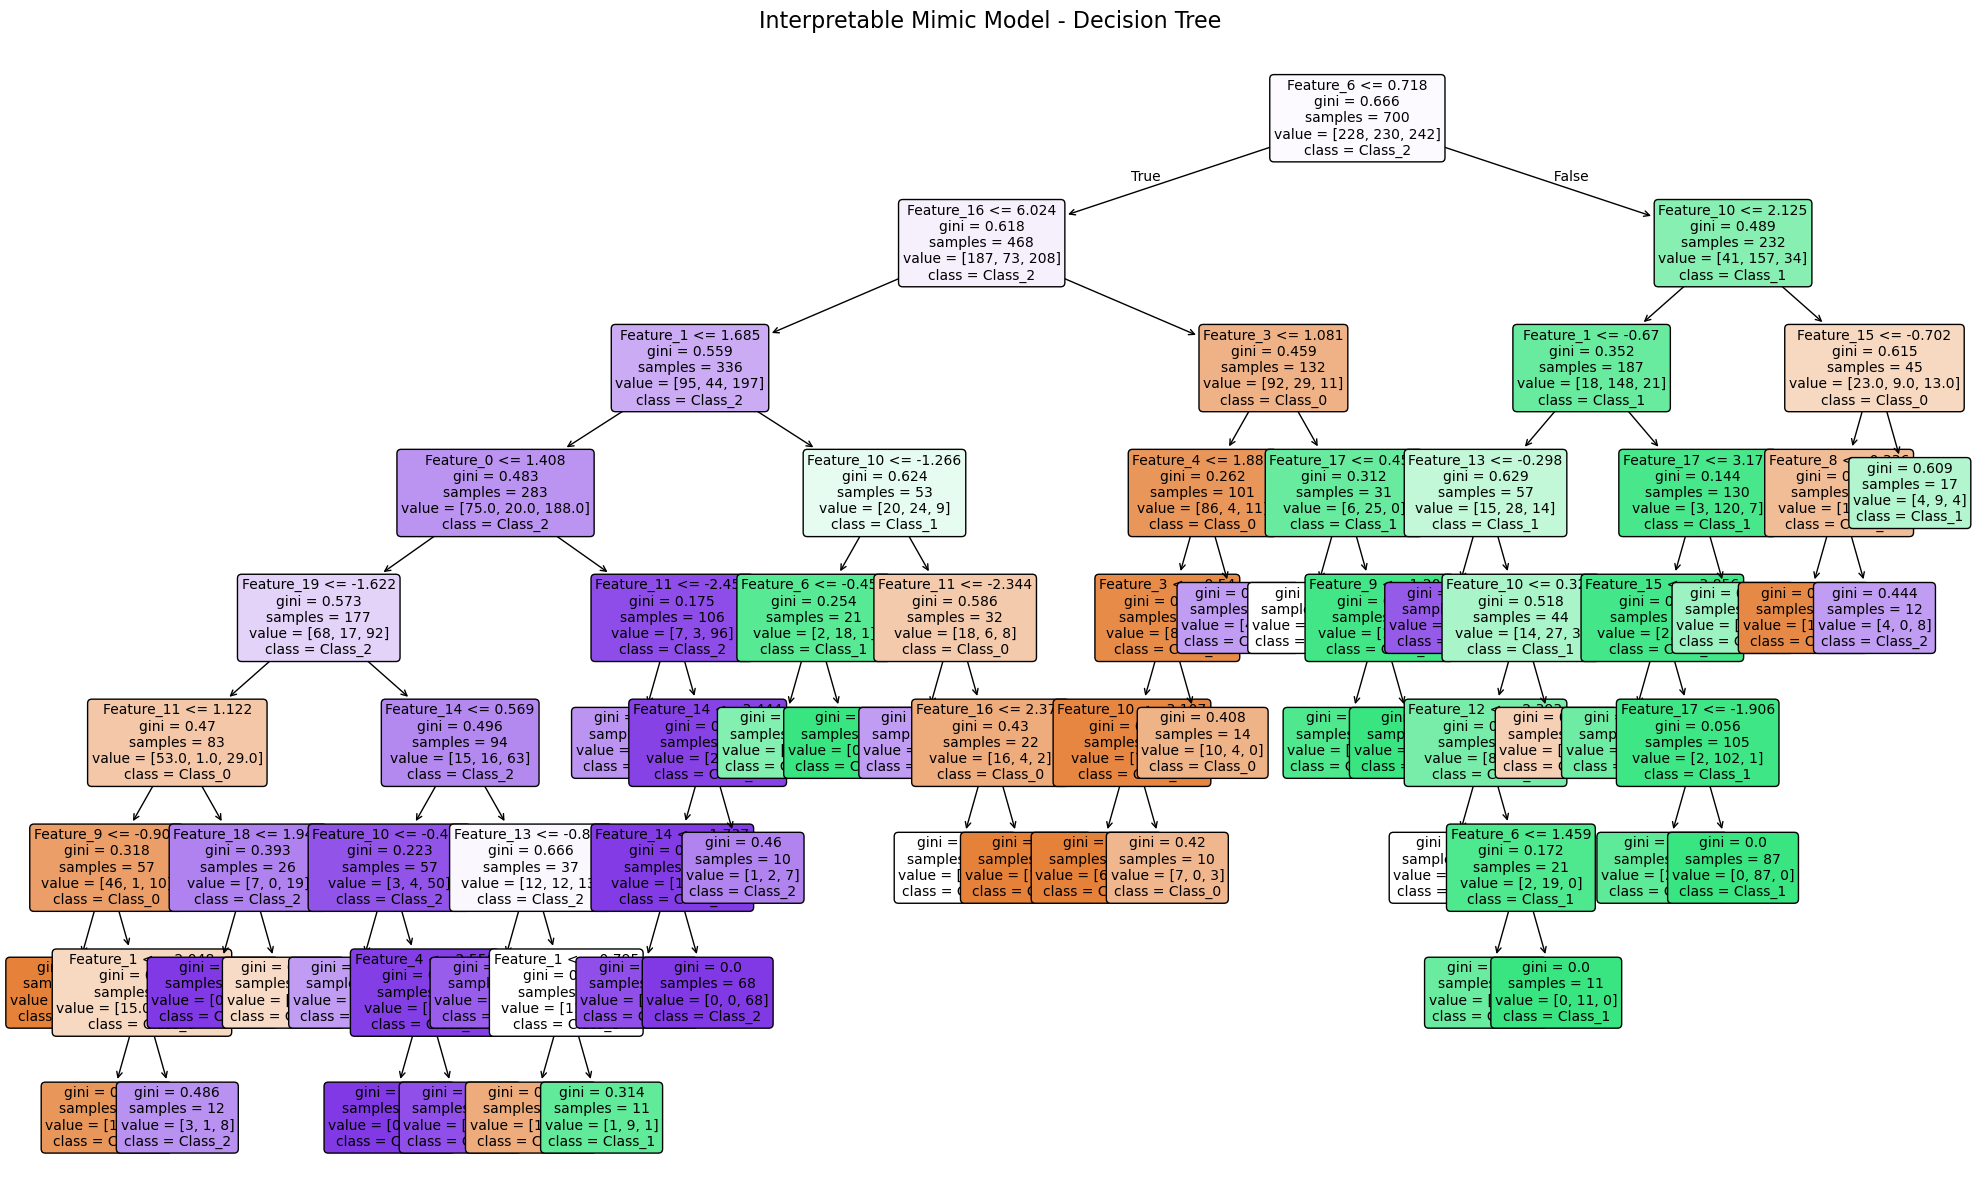


 Decision Tree Feature Importance:
   Feature_6: 0.2010
   Feature_16: 0.1368
   Feature_1: 0.1198
   Feature_10: 0.1148
   Feature_3: 0.0814
   Feature_0: 0.0525
   Feature_11: 0.0516
   Feature_19: 0.0489
   Feature_13: 0.0489
   Feature_14: 0.0330


In [4]:
analyzer = MyModelAnalyzer(
    mymodel=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=features
)
    
analyzer.run_all_analysis()

#MyModel
#analyzer = MyModelAnalyzer(mymodel, X_train, y_train, X_test, y_test)"